# **statlib**

Collection of useful functions for Advanced Statistics course, UniPD 2021/22.


## analytic tools

In [1]:
beta.from_stats <- function(mu, std) {
    # given statistics of beta distribution
    # let's go to a & b
    alpha <- (1-mu)*(mu/std)^2 - mu
    beta  <- alpha*((1/mu) - 1)
    return (alpha, beta)
}

In [2]:
frequentist.bernoulli <- function(x, n) {
    p.freq <- x/n
    p.var.freq <- p.freq*(1-p.freq)/n   # variance
}

## numerical tools

In [3]:
numerical_median <- function(pdistr, p, dp) {
    integral <- 0.0;   i <- 0;
    while(integral < 0.5) {
        i <- i+1
        integral <- integral + dp*pdistr[i]
    }
    return(p[i-1])
}

In [4]:
numinterval.one_side <- function(distr, dp, alpha, ps = NULL, side.left = TRUE, inclusive = TRUE, verbose = FALSE) {
    if(is.null(ps)) ps <- seq(0, length(distr))
    
    i <- 0;  sums <- 0;
    if(side.left) {
        if(verbose) cat('compute L side')
        limit <- alpha
    } else {
        if(verbose) cat('compute R side')
        limit <- 1-alpha
    }
    
    while(sums < limit)   {  i<-i+1;  sums <- sums + dp*distr[i]; }
    sig.idx <- i - ifelse(inclusive, 0, 1)
    sig.p <- ps[sig.idx]
    sig <- sums - ifelse(inclusive, 0, dp*distr[i])        
    
    if(verbose) cat(ifelse(side.left,'left','right'), 'limit @', 
                    sig.idx,'| area:', sig,'| p:', sig.p, '\n')
    
    return( list(side.left = side.left, inclusive = inclusive, 
                 alpha = sig, idx = sig.idx, p = sig.p )
          )
    # notes on inclusive
    # not inclusive -->   [0, sig.idx[
    #     inclusive -->   [0, sig.idx]
}

In [5]:
numinterval.two_side <- function(distr, dp, alpha, ps = NULL, verbose = FALSE) {
    
    if(is.null(ps)) ps <- seq(0, length(distr))
    i <- 0;  sums <- 0;
    
    # lower limit
    while(sums < alpha/2)   {  i<-i+1;  sums <- sums + dp*distr[i]; }
    low_sig.idx <- i              # loop index
    low_sig.p <- ps[low_sig.idx]  # corresponding p
    low_sig <- sums - dp*distr[i]    # area to the left of idx
    if(verbose)  cat(' lower limit @', low_sig.idx,'| area:', low_sig,'| p:', low_sig.p, '\n')
    
    # upper limit
    while(sums < 1-alpha/2) {  i<-i+1;  sums <- sums + dp*distr[i]; }
    upp_sig.idx <- i;   upp_sig.p <- ps[upp_sig.idx];
    upp_sig <- sums;   # area up to the higher limit
    if(verbose)  cat(' upper limit @', upp_sig.idx,'| area:', upp_sig,'| p:', upp_sig.p, '\n')
    
    return( list(alpha = low_sig + 1 - upp_sig,
                 # ^^^ return    area [0, low.idx[  U  ]upp.idx, inf[
                 low.idx = low_sig.idx, low.area = low_sig, low.p = low_sig.p,
                 # ^^^      left index (non inclusive) + area [0, low.idx[ + corresp. prob. value
                 upp.idx = upp_sig.idx, upp.area = upp_sig, upp.p = upp_sig.p
                 # ^^^      right index (inclusive) + area [0, upp.idx] + corresp. prob. value
                )
          )
}

## inference

In [6]:
inference.bernoulli <- function(x, n, prior = 'uniform', prior.alpha = 1, prior.beta = 1,
                                dp = 0.0005, conf = 0.05, do.plot = TRUE) {
    #  args:  x  successes
    #         n  total trials
    #         prior   uniform or beta
    
    ## p uniformly in [0,1]
    p <- seq(dp/2, 1, dp)
    
    ## likelihood (binomial)
    p.like <- dbinom(x, n, p)
    #p.like <- p.like/(dp*sum(p.like))  # normalize
    p.like.mean <- x/n
    #plot(p, p.like, type="l", lwd=3, col="red",
    #     ylab="P(π)", main='Coin flip likelihood')
    
    
    ## compute posterior
    if(prior == 'uniform') {
        p.prior <- dunif(x=p)
        p.post <- dbinom(x=x, size=n, prob=p)
    } else if (prior == 'beta') {
        p.prior <- dbeta(x=p, prior.alpha, prior.beta)
        post.alpha <- prior.alpha+x;  post.beta <- prior.beta+n-x;
        p.post <- dbeta(x=p, post.alpha, post.beta)
    }
    p.post.norm <- p.post/(dp*sum(p.post))
    
    ## posterior statistics
    if(prior == 'uniform') {
        best_est <- x/n
        # - credibility interval
        qs <- numinterval.two_side(p.post.norm, dp, conf, ps=p)
        q_lower <- qs$low.p;   q_upper <- qs$upp.p;
    } else if (prior == 'beta') {
        best_est <- (x+post.alpha-1)/(n+post.alpha+post.beta-2)
        std <- sqrt( (x+post.alpha-1)/(post.alpha+x) )/(n+post.alpha+post.beta-2)
        var <- std^2
        q_lower <- qbeta(conf/2, shape1 = post.alpha, shape2 = post.beta)
        q_upper <- qbeta(1 - conf/2, shape1 = post.alpha, shape2 = post.beta)
    }
    
    ## plotting
    if(do.plot) {
        plot(p, p.post.norm, type="l", lwd=3, col="red", xlab='p', ylab="P(p|x)",
             main='Bernoulli process')
        lines(p, p.prior, type="l", lwd=3, col="#006699")
        abline(v=best_est, col="grey30", lty=2)
        mtext(paste("mean =", round(best_est,3), '   '), 
              3, adj=1, line=-7, col = "grey20")
        
        legend('topright', legend = c("Posterior", "Prior", "mean"), y.intersp=1.2,
               col = c("red","#006699","grey20"), lty=c(1,1,2), lwd = 2)
    }
    
    ## return everything
    if(prior == 'uniform')
        return( list( prior.type = prior, post = p.post.norm, prior = p.prior,
                      mean = best_est, confidence = conf, interval = c(q_lower, q_upper) ) )
    return( list( prior_type = prior, post = p.post.norm, prior = p.prior,
                  mean = best_est, var = var, std = std, 
                  confidence = conf, interval = c(q_lower, q_upper)
                )
          )
}

In [7]:
inference.poisson <- function(y, prior = 'uniform', mu.max = 9, dmu = 0.0005, conf = 0.05) {
    #  arg:  y is observations
    #        prior   uniform or jeffrey
    
    ## mu uniformly in [0,1]
    mu <- seq(0, mu.max, dmu)
    
    ## compute posterior
    if(prior == 'uniform') {
        p.prior <- dunif(x=mu, min = 0, max=mu.max)
        post.alpha <- sum(y) + 1   # shape
        post.lambda <- length(y)   # rate
    } else if (prior == 'jeffrey') {
        p.prior <- 1/sqrt(mu) # improper!
        p.prior <- p.prior/sum(p.prior[-1]*dmu)
        post.alpha <- sum(y) + 1/2 # shape
        post.lambda <- length(y)   # rate
    }
    p.post <- dgamma(shape = post.alpha, rate = post.lambda, mu)
    
    ## posterior statistics
    mean <- post.alpha/post.lambda
    var  <- post.alpha/(post.lambda^2)
    median <- numerical_median(p.post, mu, dmu)
    # - credibility interval
    q_lower <- qgamma(conf/2, shape = post.alpha, rate = post.lambda)
    q_upper <- qgamma(1 - conf/2, post.alpha, post.lambda)
    
    ## plotting
    plot(mu, p.post, type="l", lwd=3, col="red", xlab='μ', ylab="P(μ|y)",
         main='Poisson process')
    lines(mu, p.prior, type="l", lwd=3, col="#006699")
    abline(v=mean, col="grey30", lty=2)
    mtext(paste("mean =", round(mean,3), '   '), 
          3, adj=1, line=-7, col = "grey20")
    
    legend('topright', legend = c("Posterior", "Prior", "mean"), y.intersp=1.2,
           col = c("red","#006699","grey20"), lty=c(1,1,2), lwd = 2)
    
    ## return everything
    return( list( prior.type = prior, post = p.post, prior = p.prior,
                  mean = mean, var = var, std = sqrt(var), median = median,
                  post.alpha = post.alpha, post.lambda = post.lambda,
                  confidence = conf, interval = c(q_lower, q_upper)
                )
          )
}

### examples

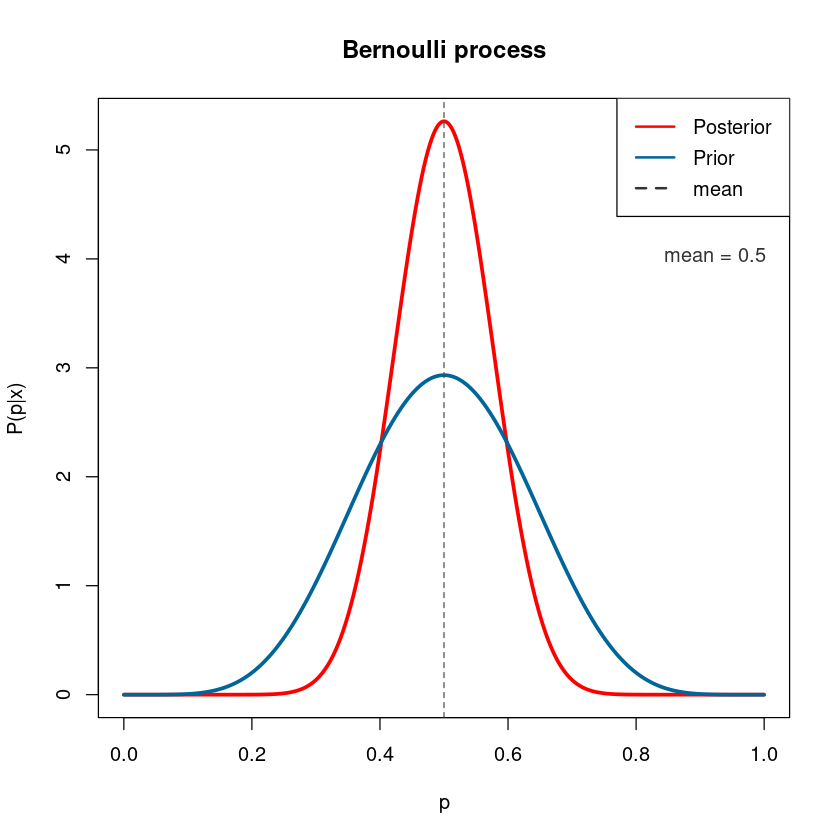

In [8]:
# coin flip outcomes
H <- TRUE;  T <- FALSE;
outcomes <- c(T, T, T, T, T, H, T, T, H, H, T, T, H, H, H, T, H, T, H, T, H, H, T, H, T, H, T, H, H, H)

x <- sum(outcomes)   # number of heads
n <- length(outcomes) # total coin flips

gg <- inference.bernoulli(x, n, prior = 'beta', prior.alpha = 7, prior.beta = 7)

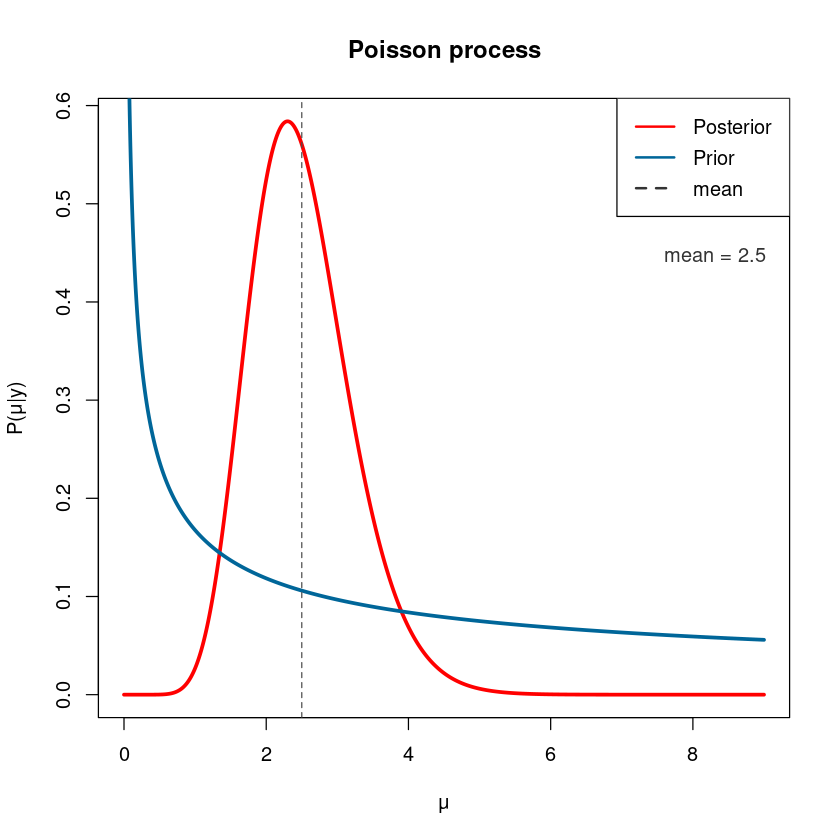

In [9]:
data <- c(4, 1, 3, 1, 3)

gg <- inference.poisson(data, prior = 'jeffrey')

## frequentist hypotesis testing

In [10]:
# ONE SIDED

# significance test parameters
p.test <- 15/100     # H_0 : p greater than 15%
signif <-  5/100

# binomial likelihood on LEFT TAIL
y <- 6   # numof failures
n <- 75  # total samples

# p-value: just sum on the left tail of likelihood
p.value <- sum( dbinom( seq(0, y, 1), size=n, p=p.test) ) 
cat( paste('p-value =', round(p.value*100,4), '%\n') )

# test result
if(p.value < signif) { 
    cat('Null hypotesis is rejected at significance', round(signif*100,2),'%\n') 
} else {
    cat('Null hypotesis cannot be rejected at significance', round(signif*100,2),'%\n')
}

p-value = 5.4353 %
Null hypotesis cannot be rejected at significance 5 %


In [11]:
# alternatively
binom.test(x = y, n = n, p = p.test,
           alternative = "less", conf.level = 0.95)
           # sign of alternative hypotesis


	Exact binomial test

data:  y and n
number of successes = 6, number of trials = 75, p-value = 0.05435
alternative hypothesis: true probability of success is less than 0.15
95 percent confidence interval:
 0.0000000 0.1517971
sample estimates:
probability of success 
                  0.08 


In [12]:

plot_frequentist.binomial <- function(p.test, y, n, oneside = TRUE, altern.left = TRUE, y.max = 30) {
    #   p.test    probability to test
    #        y    observed value
    #        n    number of samples
    
    # create the binomial distribution plot (grey)
    ys <- seq(0, y.max, 1)
    distr.fr <- dbinom(ys, size=n, p=p.test)
    barplot(distr.fr, col='grey90', names.arg=ys)
    
    # compute the closest significance
    if(oneside) {
        ni <- numinterval.one_side(distr.fr, 1, 0.05, ys, inclusive=FALSE, side.left = altern.left)
        closest_sig <- ni$alpha
        closest_sig_idx <- ni$idx
        closest_sig_p <- ni$p
        
        # highlight acceptance region
        if(altern.left)
            barplot( c(rep(0,closest_sig_idx), distr.fr[closest_sig_idx+1:length(ys)]), col='gold', add=TRUE)
        else { closest_sig <- 1-closest_sig
               barplot( distr.fr[1:closest_sig_idx], col='gold', add=TRUE)
        }
    }
    else {
        # 2 sided
        ni <- numinterval.two_side(distr.fr,1,0.05,ys)
        closest_sig <- ni$alpha
        
        barplot( c(rep(0,ni$low.idx-1), distr.fr[ni$low.idx:ni$upp.idx]), col='gold', add=TRUE)
    }

    # highlight observed value
    barplot( c(rep(0,y), distr.fr[y+1]), col='black', density=25, add=TRUE)

    legend("topright", fill = c("gold", "black"), density=c(NA,25), y.intersp=2,
           legend = c( paste("acceptance region, \nalpha =", round(closest_sig*100,2), "%"), "observed value")
           )
    return(closest_sig)
}

[1] 0.02342005

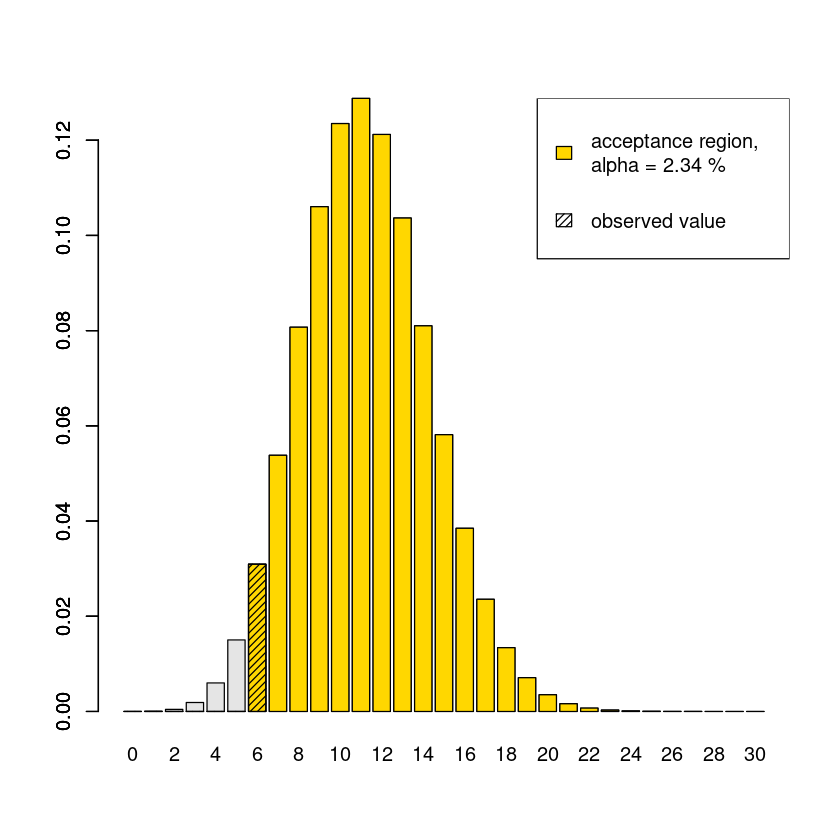

In [13]:
plot_frequentist.binomial(0.15, 6, 75, oneside = TRUE)

[1] 0.04254348

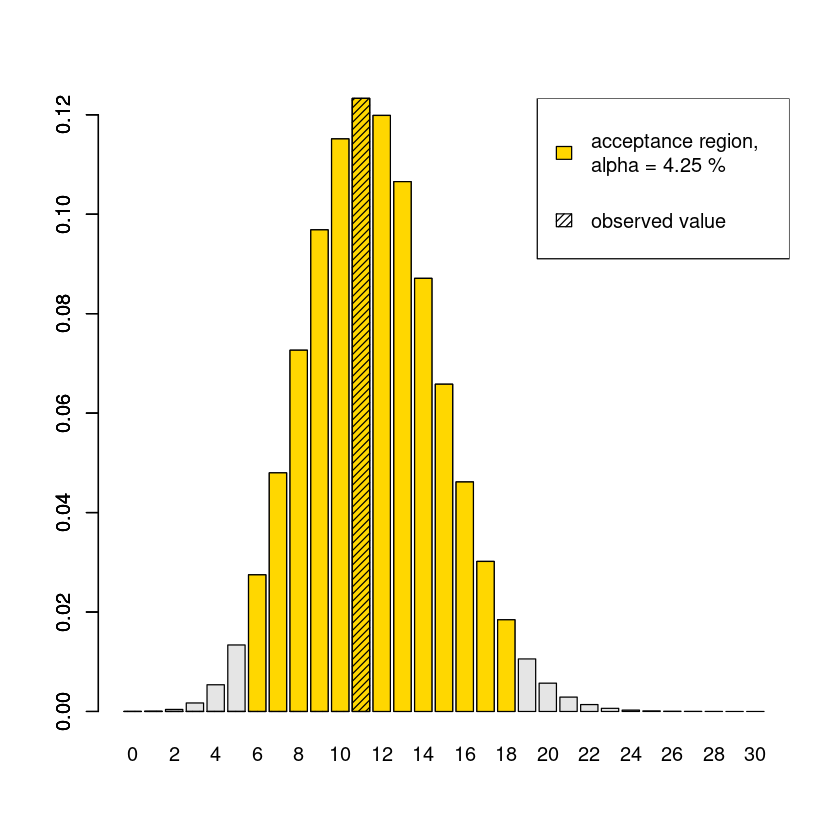

In [14]:
plot_frequentist.binomial(0.1, 11, 116, oneside = FALSE)

## bayesian hypotesis test

In [ ]:
# ONE SIDED

if(integral_over_H0 < signif) {
    # result is not due to chance
    cat('Null hypotesis is rejected at significance', round(signif*100,2),'%\n') 
} else {
    cat('Null hypotesis cannot be rejected at significance', round(signif*100,2),'%\n')
}


# TWO SIDED
# compute credible interval (low, upp)
if( (q_lower < p.test) & (p.test < q_upper) ) {
    # p is inside credible interval
    cat('Null hypotesis cannot be rejected at significance', round(signif*100,2),'%\n')
} else {
    # p is outside credible interval -> significant!
    cat('Null hypotesis is rejected at significance', round(signif*100,2),'%\n') 
}